In [1]:
# Import Required Packages

import requests
import zipfile
import io
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import math as math
import matplotlib.pyplot as plt



Lejing Lu 
# 1. House Price Dynamics

In [2]:
#download and read a .csv file of price returns by census tract 
url = "https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_AT_BDL_tract.csv"
df = pd.read_csv(url)
df

,tract,state_abbr,year,annual_change,hpi,hpi1990,hpi2000
0,1001020100,AL,1998,NaN,100.00,NaN,100.96
1,1001020100,AL,1999,-5.71,94.29,NaN,95.19
2,1001020100,AL,2000,5.05,99.05,NaN,100.00
3,1001020100,AL,2001,6.95,105.93,NaN,106.95
4,1001020100,AL,2002,7.60,113.98,NaN,115.07
...,...,...,...,...,...,...,...
1986388,56045951300,WY,2018,2.82,180.67,NaN,NaN
1986389,56045951300,WY,2019,7.49,194.21,NaN,NaN
1986390,56045951300,WY,2020,0.79,195.75,NaN,NaN
1986391,56045951300,WY,2021,14.07,223.29,NaN,NaN


In [3]:
#Filter dataframe such that the first year is 1990. Then, convert the data type of the variable
#annual change to a float.
dfFiltered = df
dfFiltered = dfFiltered[(dfFiltered['year'] >= 1990) & (dfFiltered['year'] <= 2019)]
dfFiltered = dfFiltered[dfFiltered['annual_change'] != "."]
dfFiltered['annual_change'] = dfFiltered['annual_change'].astype(float)
dfFiltered

,tract,state_abbr,year,annual_change,hpi,hpi1990,hpi2000
0,1001020100,AL,1998,NaN,100.00,NaN,100.96
1,1001020100,AL,1999,-5.71,94.29,NaN,95.19
2,1001020100,AL,2000,5.05,99.05,NaN,100.00
3,1001020100,AL,2001,6.95,105.93,NaN,106.95
4,1001020100,AL,2002,7.60,113.98,NaN,115.07
...,...,...,...,...,...,...,...
1986385,56045951300,WY,2015,-2.58,173.52,NaN,NaN
1986386,56045951300,WY,2016,2.40,177.67,NaN,NaN
1986387,56045951300,WY,2017,-1.10,175.71,NaN,NaN
1986388,56045951300,WY,2018,2.82,180.67,NaN,NaN


In [4]:
#1c  Read the crosswalk file tract-metro-crosswalk.csv and create a new dataframe consisting of a list
#of census tracts in San Diego. Note that San Diego’s metro code is 41740.
dfCrosswalk = pd.read_csv('tract-metro-crosswalk.csv')
dfSD = dfCrosswalk[dfCrosswalk['metro'] == 41740]
dfSD

,tract,metro
8498,6059032023,41740
8533,6059042103,41740
8535,6059042106,41740
8537,6059042107,41740
8539,6059042108,41740
...,...,...
10968,6073021600,41740
10969,6073021800,41740
10970,6073021900,41740
10971,6073022000,41740


In [5]:
#Read the auxiliary dataset tract-centrality.csv and drop observations with missing data on distance to the city center.
dfDistance = pd.read_csv('tract-centrality.csv')
dfDistance = dfDistance.dropna(subset=['distance_to_city_center'])
dfDistance

,tract,distance_to_city_center
0,1001020100,14.486390
1,1001020200,13.577132
2,1001020300,12.906942
3,1001020400,12.091412
4,1001020500,10.527886
...,...,...
55311,56043000200,81.299417
55312,56043000301,98.385588
55313,56043000302,98.707554
55314,56045951100,68.830917


In [6]:
#Merge the dataframe on centrality with the dataframe containing the list of San Diego census
#tracts, using an inner join. 
dfSD = dfDistance.merge(dfSD, how = 'inner', left_on = 'tract', right_on = 'tract')

In [7]:
dfSD = dfFiltered.merge(dfSD, how = 'inner', left_on = 'tract', right_on = 'tract')

In [8]:
#After performing the merge, sort census tracts into 5 quintiles based on their distance to San
#Diego’s city center. 
dfSD['quintile'] = pd.qcut(dfSD['distance_to_city_center'], 5, labels = False) + 1

In lecture, we made an analogy to the stock market by calling census tracts “stocks”: if there is substantial house price variation within census tracts,is  this analogy still appropriate? What would be the more appropriate analogue to a “stock” if there is substantial house price variation within census tracts?

Maybe bonds?

In [9]:
#calculate average annual house price and standard deviation of return for each quintile
meanSD = dfSD.groupby('quintile')['annual_change'].mean()
sdSD = dfSD.groupby('quintile')['annual_change'].std()
print(meanSD)
print(sdSD)

quintile
1    5.662363
2    4.873536
3    4.584100
4    4.415206
5    4.381964
Name: annual_change, dtype: float64
quintile
1    11.899407
2    10.267739
3    10.195707
4     9.195459
5    10.824235
Name: annual_change, dtype: float64


    First quintile has the highest average return, fifth quintile has lowest return. That is suggesting there is a negative relationship between average return and distance to the city, closer the distance, the higher the return.
    There does not seem to be a relationship between standard deviation of return and distance to the city center. Investors typically are risk-averse, it makes sence that closer to the downtown, the higher the return. Because closer to the center usually means the area is already established, there are more resources and more desireable by the population. Therefore the risk is lower compared to other undevelopped part (bigger distance to center).
    The Sharpe ratio (risk-adjusted return) decreases as quintile increases(distance from center increases). The risk adjusted return has a negative relationship with the distance from center. This ratio use statistic principle of mean/sqrt(var) to adjust for the different volatility (similar to how in normal distribution, we would adjust Z-distribution by (x-mean)/sd to transfrom to Z(0,1)). It indicates how much excess return an investment gets for each unit of risk it rakes on, higher is better. Sharpe ratio and distance to the city center are negatively correlated.  The closer to the city center, the higher Sharpe ratio. The further to the city center, Sharpe ratio is lower.

In [10]:
Sharpe_ratio = meanSD/sdSD
Sharpe_ratio

quintile
1    0.475853
2    0.474645
3    0.449611
4    0.480151
5    0.404829
Name: annual_change, dtype: float64

    Although Price Growth one indication of return, Return = Capitalization rate+ Price Growth. Capitalization Rate, which is rent-expense. Rent is monthly income generated from renting out the property. Rent to Price ratio might not be consistant across different centrality. Expense could include HOA, Taxes, repair cost, management fee, etc. The Expense and rent ratio is not the same for all properties, therefore we cannot conclude total return is higher in city center with only Price Growth. If we have these information, we could use these many parameters to do a new analysis of total growth rate, or we could perform the same task we just did by switching the parameter to each of the other component to get individual relationship of these component to the annual change in return. 

# 2.Mortgage Underwriting 
Study the probability a mortgage loan application is denied based on (a)
the applicant’s loan-to-income ratio (LTI); and (b) the applicant’s race. Perform this analysis using data from the Home Mortgage Disclosure Act (HMDA). 

In [11]:
#Read the file hmda-2016.csv as a dataframe.
df2 = pd.read_csv('hmda-2016.csv')

Create a new dataframe consisting of a random 80% subsample of the full data. Sample without replacement.

In [12]:
dfs = df2.sample(frac = 0.80, replace = False, random_state = 1)
dfs

,year,id,agency,loanType,propType,loanPurpose,occupancy,amount,action,msa,...,tract,appEth,appRace1,appSex,income,purchaserType,editStatus,tractMSAInc,numOwnerOccUnits,num1to4FamUnits
138305,2016,22257,3,1,1,1,1,28,1,NA,...,9703.00,2,5,2,0033,0,,099.52,00000858,00001245
62574,2016,0000451965,9,1,1,3,1,175,6,46060,...,40.44,2,5,1,0130,3,,188.57,1351,1708
162126,2016,23-2470039,7,1,1,3,1,411,4,40140,...,406.13,2,2,1,0095,0,,168.64,2681,3078
27292,2016,41-1795868,7,2,1,3,1,77,4,NA,...,9501.00,2,3,2,0052,0,,109.69,00000784,00001161
139388,2016,76-0629353,7,1,1,1,1,200,6,26420,...,6729.0,2,2,1,0112,1,,124.13,00005978,6862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19685,2016,17117,5,1,1,1,3,113,2,NA,...,NA,2,5,2,0049,0,,NA,NA,NA
9057,2016,26-0021318,7,1,1,3,1,60,3,19340,...,0202.00,2,5,1,0079,0,,077.28,00001047,00001346
150344,2016,0000066328,5,2,1,1,1,53,3,19380,...,301.0,3,5,1,0001,0,,66.65,00000998,1640
125892,2016,146672,9,1,1,3,1,179,3,47664,...,1360.0,2,2,2,0193,0,,141.35,765,870


In [13]:
#Filter the dataset such that: the edit status is empty; the loan is for the purchase of a home; 
#the property is single family (i.e. one-to-four family); the property is owner-occupied;
#and the borrower’s income is non empty.
dfs = dfs[(dfs['editStatus'] == " ") & (dfs['loanPurpose'] == 1) & (dfs['msa'] != "NA") & 
          (dfs['occupancy'] == 1) & (dfs['propType'] == 1) & (dfs['income'] != "NA  ") & 
          (dfs['income'] != "NA")]

Create the following new variables: an indicator for whether the loan application was denied;
the borrower’s loan-to-income ratio (LTI); and an indicator for whether the borrower is AfricanAmerican or Hispanic. To construct the last variable, review the HMDA code sheet here, and
note the value for Race which codes whether the borrower is African-American and the value for
Ethnicity which codes whether the borrower is Hispanic.

In [14]:
#if loan application is denied
dfs['denied'] = (dfs["action"] == 3).astype(int)
#loan to income ratio
dfs['income'] = dfs['income'].astype(float) 
dfs['amount'] = dfs['amount'].astype(float) 
dfs['lti'] = dfs['amount'] / dfs['income']
#minority 
dfs['minority'] = ((dfs['appEth'] == 1) | (dfs['appRace1'] == 3)).astype(int)
dfs

C:\Users\vivia\AppData\Local\Temp\ipykernel_19148\2621871534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['denied'] = (dfs["action"] == 3).astype(int)
C:\Users\vivia\AppData\Local\Temp\ipykernel_19148\2621871534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['income'] = dfs['income'].astype(float)
C:\Users\vivia\AppData\Local\Temp\ipykernel_19148\2621871534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,year,id,agency,loanType,propType,loanPurpose,occupancy,amount,action,msa,...,appSex,income,purchaserType,editStatus,tractMSAInc,numOwnerOccUnits,num1to4FamUnits,denied,lti,minority
138305,2016,22257,3,1,1,1,1,28.0,1,NA,...,2,33.0,0,,099.52,00000858,00001245,0,0.848485,0
139388,2016,76-0629353,7,1,1,1,1,200.0,6,26420,...,1,112.0,1,,124.13,00005978,6862,0,1.785714,0
46254,2016,3827009995,7,4,1,1,1,158.0,5,NA,...,1,43.0,0,,108.58,00002282,00003031,0,3.674419,1
161045,2016,74-2508160,7,3,1,1,1,255.0,1,41700,...,1,79.0,2,,138.83,00000992,00001123,0,3.227848,1
143522,2016,31-1197926,9,1,1,1,1,311.0,6,39300,...,1,125.0,1,,115.41,00001717,00002179,0,2.488000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19652,2016,26-0595342,7,1,1,1,1,75.0,1,39580,...,2,103.0,0,,78.56,1017,1418,0,0.728155,0
154178,2016,20-2749403,1,1,1,1,1,213.0,1,23104,...,1,83.0,7,,161.88,00000907,1016,0,2.566265,1
13491,2016,02-0640271,7,2,1,1,1,216.0,4,21780,...,1,92.0,0,,125.39,00002894,00003137,0,2.347826,0
97140,2016,39-1767726,7,1,1,1,1,202.0,1,24580,...,1,131.0,6,,113.3,3072,3508,0,1.541985,0


Use a logistic regression to estimate the probability that a borrower is denied as a function of her
loan-to-income ratio (LTI) and a constant. Note that this regression is similar to that estimated
in lecture, except that the outcome variable differs (i.e. loan denial vs. loan sale). What are
the estimated coefficients on the variables in your regression (i.e. β0, β1)? Using these estimated
coefficients, calculate each loan application’s probability of being denied.


β0 = -2.5857
β1 = 0.0559

probability of being denied = 1/(1+exp[-β0 -β1*LTI]) = 1/(1+exp[2.5857-0.0559*LTI)

Optimization terminated successfully.
         Current function value: 0.282519
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.003     
Date:               2024-02-04 10:13 AIC:              22658.6202
No. Observations:   40094            BIC:              22675.8182
Df Model:           1                Log-Likelihood:   -11327.   
Df Residuals:       40092            LL-Null:          -11365.   
Converged:          1.0000           LLR p-value:      3.1634e-18
No. Iterations:     7.0000           Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -2.5857     0.0309   -83.7544   0.0000   -2.6462   -2.5252
x1        0.0559     0.0082     6.8607   0.0000    0.0400 

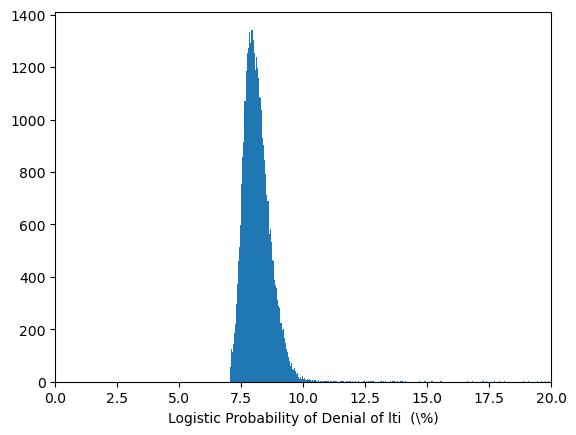

In [33]:
#2e: prepare data
dfO = dfs

x = sm.add_constant(np.array(dfO['lti']))
y = np.array(dfO['denied'])

#resultOLS = sm.OLS(y, x).fit()
resultLogit_lti = sm.Logit(y, x).fit()

#print(resultOLS.summary())
print(resultLogit_lti.summary2()) 
plot = plt.hist(100/(1+np.exp(-np.sum(x*resultLogit_lti.params,axis=1))),bins='auto')
plt.xlim([0,20])
plt.xlabel("Logistic Probability of Denial of lti  (\%)")
plt.savefig("Log-prob-denial-lti.png")

    The sign of the coefficient is positive. This makes sence because higher loan-to-income yields bigger risk, the borrower is less likely to pay back according to scheule, so more likely to get denied. One advantage to use OLS regression is that we bet B0 and B1, it is easy to interpret the relationship between two parameters, and easy to predict likelihood of denial when lti is given. Since we just need to plug into this one equation: probability of denial = β0 + β1 *LTI 

Using a similar methodology, use a logistic regression to estimate the probability that a borrower is denied as a function of her loan-to-income ratio (LTI), a constant, and an indicator for whether the borrower is African-American or Hispanic. 

β0 = -2.5547
β1 = 0.0545

probability of being denied = 1/(1+exp[-β0 -β1*LTI]) = 1/(1+exp[2.5547-0.0545*LTI)

In [23]:
xg = sm.add_constant(np.array(dfO['lti'],dfO['minority']))
y = np.array(dfO['denied'])

#resultOLS = sm.OLS(y, x).fit()
resultLogit_minority = sm.Logit(y, xg).fit()
print(resultLogit_minority.summary2()) 


Optimization terminated successfully.
         Current function value: 0.282537
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.003     
Date:               2024-02-04 10:08 AIC:              22660.0664
No. Observations:   40094            BIC:              22677.2644
Df Model:           1                Log-Likelihood:   -11328.   
Df Residuals:       40092            LL-Null:          -11365.   
Converged:          1.0000           LLR p-value:      6.5807e-18
No. Iterations:     7.0000           Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -2.5547     0.0275   -92.8437   0.0000   -2.6086   -2.5007
x1        0.0545     0.0080     6.7873   0.0000    0.0387 

    Two distribution looks different because they have different parameters, one is only with LTI data, one is with LTI and minority data. I think the part g with lti and minority data gives more accurate prediction because there are more parameters, so less confounding variables, maing the prediction more controlled and less error. 

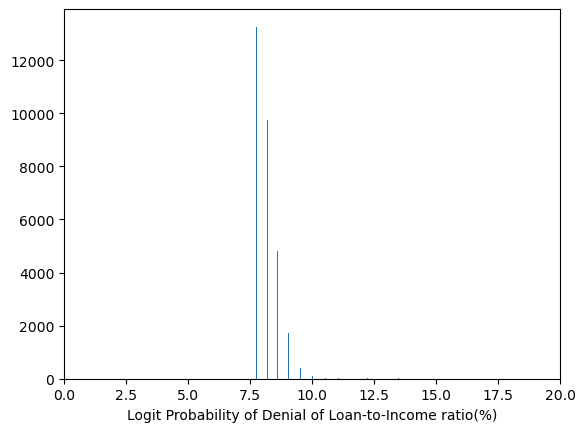

In [29]:
plot_g = plt.hist(100 / (1 + np.exp(- np.sum(xg * resultLogit_lti.params, axis = 1))), bins = 'auto')
plt.xlim([0,20])
plt.xlabel("Logit Probability of Denial of Loan-to-Income ratio(%)")
plt.savefig("logit-denied-lti-race.png")

    We only analyz owner occupied homes because loan to income ratio can be different from owner-occupied properties and non-owner-occupied properties(usually rental/investment property). Because first, there is different purpose for the property, owner occupied is primary resident, there will not be rent income, whereas investment property earns rental income, so the cashflow differs, and return differs. Secondly, usually there would be a lower interest rate for owner-occupied property, and higher interest rate and requirements for investment properties, the underwritting procedure is different. Non-own-occupied property has higher risk since rental income and property damage could vary. Therefore, the loan-to-income ratio is less informative for non-owner-occupied properties. 
